## SI epidemic simulations: node removal

In [1]:
import networkx as nx
import EoN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec

from tqdm.notebook import tqdm

In [2]:
TAU = 0.1
TMAX = 20.0
N_TRIALS = 5
N_RUNS = 5

In [3]:
# Import Reddit Hyperlink network
edges = np.loadtxt('data/edges.csv', delimiter=',', dtype=int, skiprows=1)
G = nx.Graph()
G.add_edges_from(edges)

# Import communities
node_community = pd.read_csv('data/task1/communities.csv', index_col=0)

# Extract 5 largest communities
print(node_community.value_counts().head())

top_community_ids = node_community.value_counts().head().index.get_level_values(0).to_list()
top_community_nodes = {community_rank: node_community[node_community == community_id].dropna().index.to_list()
                       for community_rank, community_id in enumerate(top_community_ids)}

modularity_class
11                  5757
8                   5358
7                   4408
16                  2951
10                  2334
dtype: int64


### Functions

In [4]:
def simulate_si(G: nx.Graph, tau: float, tmax: float, top_community_nodes: dict[int, list[int]], n_runs: int) -> np.ndarray:
    """Docstring"""

    t_grid = np.linspace(0, tmax, 100)
    infected = np.zeros((n_runs, len(top_community_nodes), len(t_grid)))

    for run in range(n_runs):
        initial_infected = np.random.choice(top_community_nodes[0])
        
        sim = EoN.fast_SIR(G, tau, gamma=0, initial_infecteds=initial_infected, tmax=tmax, return_full_data=True)
        
        for community, nodes in top_community_nodes.items():
            I = [sum([1 for status in sim.get_statuses(nodes, t).values() if status == 'I']) for t in t_grid]
            infected[run, community] = I
        
    mean_infected = np.mean(infected, axis=0)

    return mean_infected

In [5]:
def remove_nodes(G: nx.Graph, percent: float, top_community_nodes: dict[int, list[int]], top_node_eigenvector: pd.DataFrame=None) -> nx.Graph:
    """Remove nodes from the network."""
    
    # Randomly remove nodes from the network
    G_reduced = G.copy()
    if top_node_eigenvector is not None:
        # Remove nodes with highest eigenvector centrality
        G_reduced.remove_nodes_from(top_node_eigenvector.index[:int(percent * len(G.nodes()))])
        
        # Filter out removed nodes from top communities
        top_community_nodes_reduced = {community: [node for node in nodes if node in G_reduced.nodes()]
                                       for community, nodes in top_community_nodes.items()}
    else:
        # Remove nodes randomly
        G_reduced.remove_nodes_from(np.random.choice(G.nodes(), int(percent * len(G.nodes()))))
    
        # Filter out removed nodes from top communities
        top_community_nodes_reduced = {community: [node for node in nodes if node in G_reduced.nodes()]
                                       for community, nodes in top_community_nodes.items()}
    
    return G_reduced, top_community_nodes_reduced

In [6]:
def run_trials(G: nx.Graph, tau: float, tmax: float, top_community_nodes: dict[int, list[int]], n_trials: int, n_runs: int, top_node_eigenvector: pd.DataFrame=None) -> np.ndarray:
    """Docstring"""
    
    # Percent of nodes to remove
    remove_percents = [0.05, 0.1, 0.15, 0.2, 0.25]

    # Dictionary to store final results
    remove_percent_infected = {}

    for remove_percent in remove_percents:
        
        # Array to store results of each trial
        mean_trial_infected = np.zeros((n_trials, len(top_community_nodes), len(np.linspace(0, tmax, 100))))
        
        print(f"Random: {remove_percent * 100}%")

        for trial in tqdm(range(n_trials)):

            # Remove nodes from the network (randomly or by eigenvector centrality)
            G_reduced, top_community_nodes_reduced = remove_nodes(G, remove_percent, top_community_nodes, top_node_eigenvector)

            # Filter out removed nodes from top communities
            top_community_nodes_reduced = {community: [node for node in nodes if node in G_reduced.nodes()]
                                           for community, nodes in top_community_nodes.items()}

            # Run simulations
            mean_run_infected = simulate_si(G_reduced, tau=tau, tmax=tmax, n_runs=n_runs,
                                            top_community_nodes=top_community_nodes_reduced)

            # Store results
            mean_trial_infected[trial] = mean_run_infected
        
        # Average over trials
        mean_trial_infected = np.mean(mean_trial_infected, axis=0)

        # Store results
        remove_percent_infected[remove_percent] = mean_trial_infected
    
    return remove_percent_infected

In [7]:
def plot_remove_percent_infected(remove_percent_infected: dict[float, np.ndarray], title: str, log: bool=False, save: bool=False) -> None:
    """Docstring"""
    
    fig = plt.figure(figsize=(6, 8))
    fig.suptitle(f"SI epidemic: infection curve\nfor top communities after {title} node removal\ntau={TAU}, tmax={TMAX}, n_runs={N_RUNS}, n_trials={N_TRIALS}")
    gs = gridspec.GridSpec(3, 4, figure=fig)

    axs = [fig.add_subplot(gs[0, :2])]
    axs += [fig.add_subplot(gs[0, 2:], sharex=axs[0], sharey=axs[0]),
            fig.add_subplot(gs[1, :2], sharex=axs[0], sharey=axs[0]),
            fig.add_subplot(gs[1, 2:], sharex=axs[0], sharey=axs[0]),
            fig.add_subplot(gs[2, :2], sharex=axs[0], sharey=axs[0])]
    
    for ax, (remove_percent, data) in zip(axs, remove_percent_infected.items()):
        for i in range(5):
            ax.plot(np.linspace(0, TMAX, 100), data[i], label=f"Community {i + 1}")
        ax.set_title(f"Nodes removed: {remove_percent * 100}%")
        ax.set_xlabel("Time")
        ax.set_ylabel("Infected nodes")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    legend = fig.legend(*ax.get_legend_handles_labels(), loc='lower right', bbox_to_anchor=(0.9, 0.1))
    
    if log:
        axs[0].set_yscale("log")
    
    fig.tight_layout()

    if save:
        fig.savefig(f"results/task4/tau{str(TAU).replace('.', '_')}_tmax{str(TMAX).replace('.', '_')}_ntrials{N_TRIALS}_nruns{N_RUNS}_{title.lower()}_{'log' if log else 'lin'}.png", dpi=fig.dpi, bbox_inches='tight')
    
    plt.show()

## Random

In [8]:
# Run trials
remove_percent_infected_random = run_trials(G, tau=TAU, tmax=TMAX, top_community_nodes=top_community_nodes, n_trials=N_TRIALS, n_runs=N_RUNS)

Random: 5.0%


  0%|          | 0/5 [00:00<?, ?it/s]

Random: 10.0%


  0%|          | 0/5 [00:00<?, ?it/s]

Random: 15.0%


  0%|          | 0/5 [00:00<?, ?it/s]

Random: 20.0%


  0%|          | 0/5 [00:00<?, ?it/s]

Random: 25.0%


  0%|          | 0/5 [00:00<?, ?it/s]

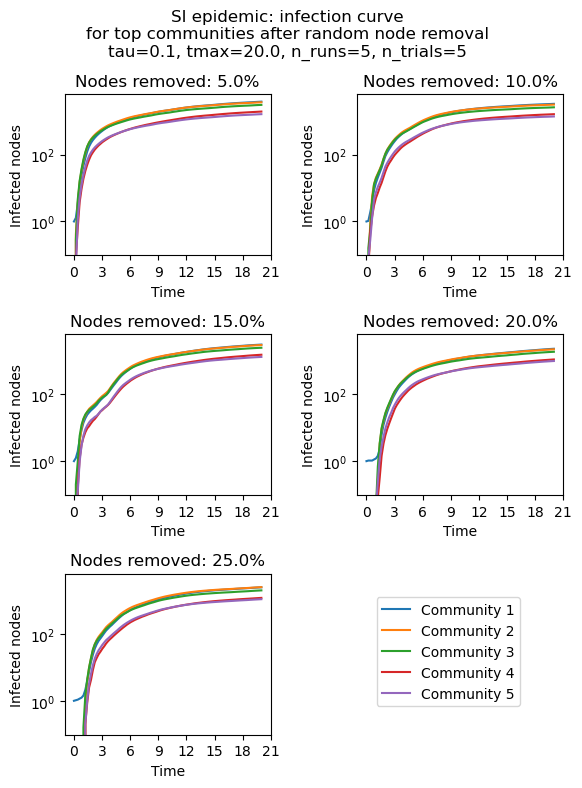

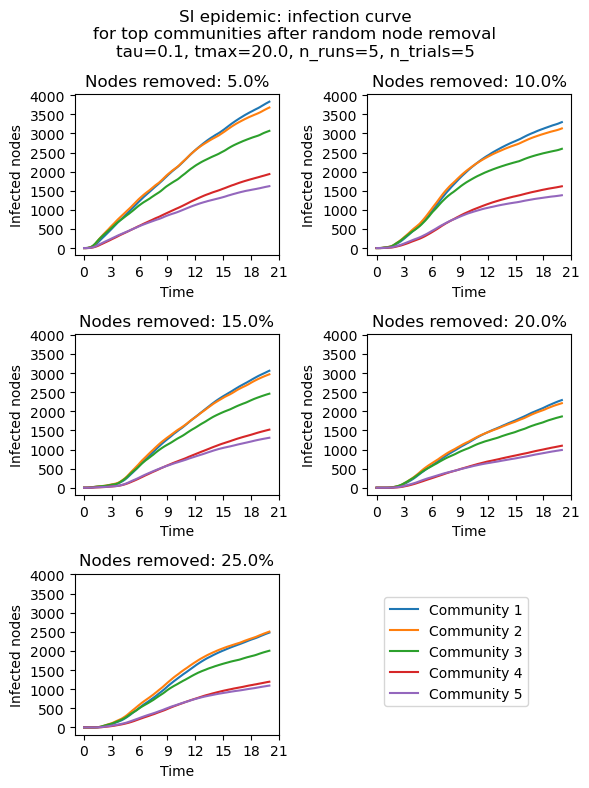

In [9]:
# Plot results
plot_remove_percent_infected(remove_percent_infected_random, title='random', log=True, save=True)
plot_remove_percent_infected(remove_percent_infected_random, title='random', log=False, save=True)

## Eigenvector

In [10]:
# Import eigenvector centralities
node_eigenvector = pd.read_csv('data/task2/eigenvector_centrality.csv', index_col=0)

# Sort nodes by eigenvector centrality
top_node_eigenvector = node_eigenvector.sort_values(by='eigenvector', ascending=False)

In [11]:
# Run trials
remove_percent_infected_eigenvector = run_trials(G, tau=TAU, tmax=TMAX, top_community_nodes=top_community_nodes, n_trials=1, n_runs=N_RUNS, top_node_eigenvector=top_node_eigenvector)

Random: 5.0%


  0%|          | 0/1 [00:00<?, ?it/s]

Random: 10.0%


  0%|          | 0/1 [00:00<?, ?it/s]

Random: 15.0%


  0%|          | 0/1 [00:00<?, ?it/s]

Random: 20.0%


  0%|          | 0/1 [00:00<?, ?it/s]

Random: 25.0%


  0%|          | 0/1 [00:00<?, ?it/s]

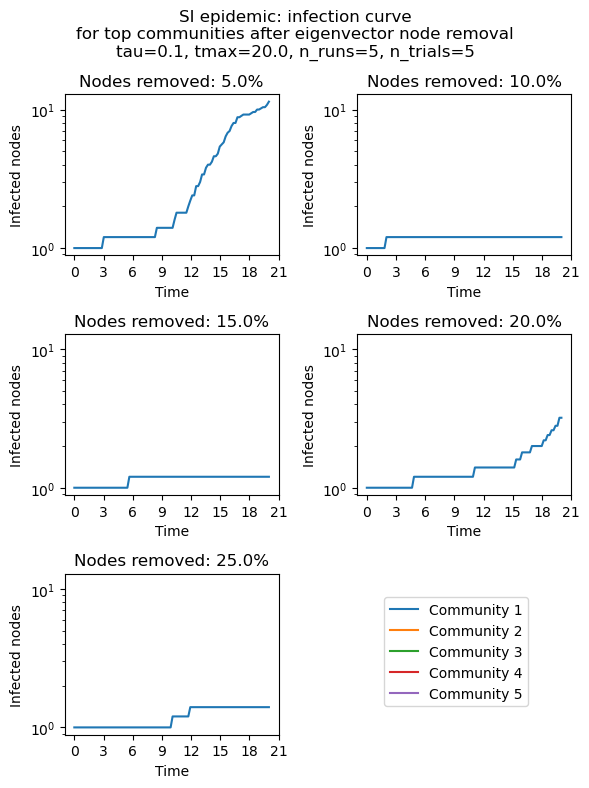

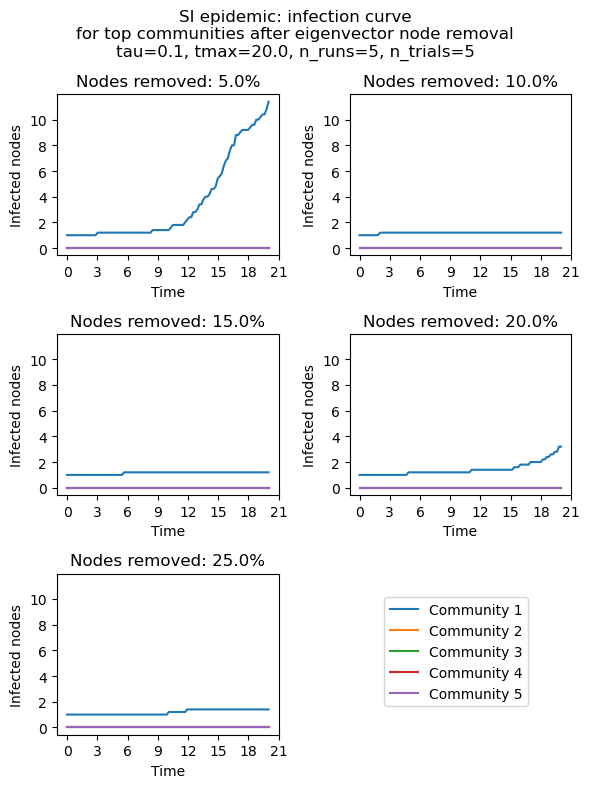

In [12]:
# Plot results
plot_remove_percent_infected(remove_percent_infected_eigenvector, title='eigenvector', log=True, save=True)
plot_remove_percent_infected(remove_percent_infected_eigenvector, title='eigenvector', log=False, save=True)

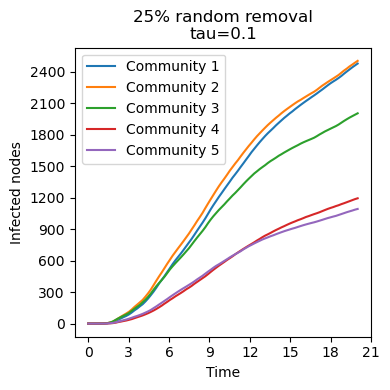

In [13]:
# Plot specific 25% removal results
data = remove_percent_infected_random[0.25]

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title(f"25% random removal\ntau={TAU}")

for i in range(5):
    ax.plot(np.linspace(0, TMAX, 100), data[i], label=f"Community {i + 1}")
ax.set_xlabel("Time")
ax.set_ylabel("Infected nodes")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()

fig.tight_layout()

plt.show()

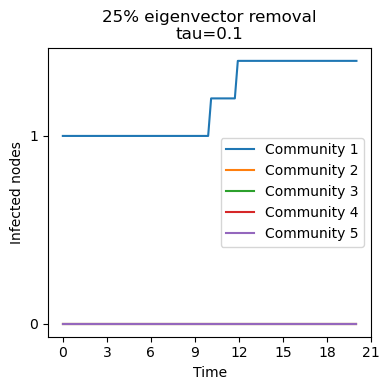

In [14]:
data = remove_percent_infected_eigenvector[0.25]

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title(f"25% eigenvector removal\ntau={TAU}")

for i in range(5):
    ax.plot(np.linspace(0, TMAX, 100), data[i], label=f"Community {i + 1}")
ax.set_xlabel("Time")
ax.set_ylabel("Infected nodes")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()

fig.tight_layout()

plt.show()